# Stock Price Prediction Using LSTM and Optuna

This notebook addresses the task of predicting the next-day stock return (March 31, 2022) for 442 companies using historical time-series data from April 5, 2010 to March 30, 2022.


## Import Libraries

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import optuna
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/opt/anaconda3/envs/webscience1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Seed Data

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Load & Explore Data

Load the `train.csv` and `sample_submission.csv` files and inspect the shape and date range. The data consists of stock return values for 442 companies.

Each row represents a company, and each column (after "ID") is a trading day's return.

**Preprocessing & Scaling**

This involves scaling the training and validation data using `MinMaxScaler`, only fitting the scaler on the training set to prevent data leakage. The data is scaled in the preprocess_data for the TimeSeriesSplit and also in the objective function that uses the 90:10 split. The 90:10 split produced a lower mse score and was used intead.


In [4]:
train_path = "train.csv"
submission_path = "sample_submission.csv"

In [5]:
def load_data():
    """
    Load training and submission data.
    """
    data = pd.read_csv(train_path)
    submission_sample_data = pd.read_csv(submission_path)

    print("Dataset Info:")
    print(f"Number of companies: {data.shape[0]}")
    print(f"Number of days: {data.shape[1]}")
    print(f"Date range: {data.columns[1]} to {data.columns[-1]}")


    # Transpose: dates become rows and companies become columns.
    data_t = data.set_index('ID').transpose()
    data_t.index = pd.to_datetime(data_t.index, dayfirst=True)
    data_t.sort_index(inplace=True)

    # Convert values to numeric and fill missing values.
    data_t = data_t.apply(pd.to_numeric, errors='coerce').fillna(0)

    return data, data_t, submission_sample_data

def preprocess_data():
    """
    Load and preprocess time series data with robust handling
    """
    # Read data
    df = pd.read_csv(train_path)
    
    # Separate ID and numerical data
    ids = df['ID']
    data = df.drop('ID', axis=1)
    
    # Convert columns to datetime
    data.columns = pd.to_datetime(data.columns, dayfirst=True)
    
    # Transpose for time series analysis
    data_transposed = data.T

    # NOrmalize data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_data = scaler.fit_transform(data_transposed)

    return ids, normalized_data, scaler
    

data, data_t, submission_sample_data = load_data()

Dataset Info:
Number of companies: 442
Number of days: 3022
Date range: 05/04/2010 to 31/03/2022


In [6]:
data.head()

,ID,05/04/2010,06/04/2010,07/04/2010,08/04/2010,09/04/2010,12/04/2010,13/04/2010,14/04/2010,15/04/2010,...,18/03/2022,21/03/2022,22/03/2022,23/03/2022,24/03/2022,25/03/2022,28/03/2022,29/03/2022,30/03/2022,31/03/2022
0,company_0,1.30,0.19,0.46,-0.23,1.20,-0.26,-0.34,1.64,1.21,...,-0.36,0.05,0.30,-3.10,0.04,0.86,0.31,0.95,0.68,-0.52
1,company_1,-0.83,0.62,-2.74,6.33,1.32,4.52,0.05,3.94,5.01,...,2.20,-3.67,3.20,-1.61,2.92,0.93,1.55,3.96,0.41,1.08
2,company_2,-0.02,0.13,-0.70,0.23,1.50,-0.23,1.35,2.26,0.37,...,-0.16,-0.74,2.52,-2.06,1.57,0.10,0.90,3.05,-1.24,-1.26
3,company_3,-1.10,-0.73,-2.98,1.98,3.00,1.01,3.60,4.30,1.05,...,2.47,-2.41,1.10,-4.08,2.09,2.02,2.74,2.33,0.80,-0.91
4,company_4,2.23,-1.45,-1.74,-1.13,0.80,1.29,0.62,3.06,-0.73,...,1.28,-1.96,0.19,-2.28,-1.13,-1.53,-0.64,2.32,-1.64,-4.58


In [7]:
data_t.head()

ID,company_0,company_1,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,...,company_432,company_433,company_434,company_435,company_436,company_437,company_438,company_439,company_440,company_441
2010-04-05,1.30,-0.83,-0.02,-1.10,2.23,0.99,2.05,2.32,1.02,-1.32,...,1.16,1.70,0.52,0.21,1.34,-2.22,2.29,1.51,-2.45,0.00
2010-04-06,0.19,0.62,0.13,-0.73,-1.45,0.47,-1.08,-0.24,0.49,0.44,...,0.21,2.51,0.05,-0.25,0.18,-0.84,-0.26,0.94,-3.75,0.98
2010-04-07,0.46,-2.74,-0.70,-2.98,-1.74,-0.59,-1.00,-0.67,-1.97,-0.36,...,-0.65,-2.14,0.62,-0.71,-0.42,-1.55,0.75,0.12,0.24,-1.38
2010-04-08,-0.23,6.33,0.23,1.98,-1.13,-0.05,0.14,-0.12,-0.25,0.25,...,-0.42,0.99,-0.46,0.58,-0.42,1.47,-1.31,0.80,2.71,-0.61
2010-04-09,1.20,1.32,1.50,3.00,0.80,2.10,1.99,1.70,0.99,0.19,...,1.83,2.28,0.21,2.17,0.86,0.42,1.04,0.80,0.75,-0.07


In [8]:
submission_sample_data.head()

,ID,value
0,company_0,0
1,company_1,0
2,company_2,0
3,company_3,0
4,company_4,0


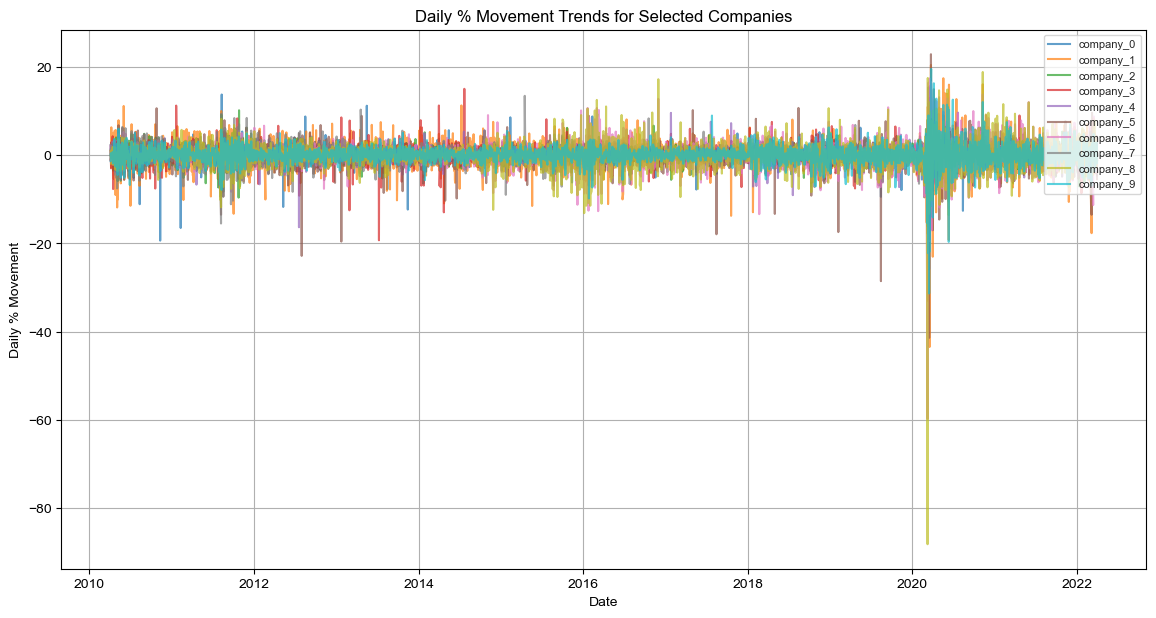

In [9]:
# First ten companies
selected_companies = data_t.columns[:10]

plt.figure(figsize=(14, 7))
for company in selected_companies:
    plt.plot(data_t.index, data_t[company], label=company, alpha=0.7)
sns.set_style("white") 
plt.xlabel('Date')
plt.ylabel('Daily % Movement')
plt.title('Daily % Movement Trends for Selected Companies')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

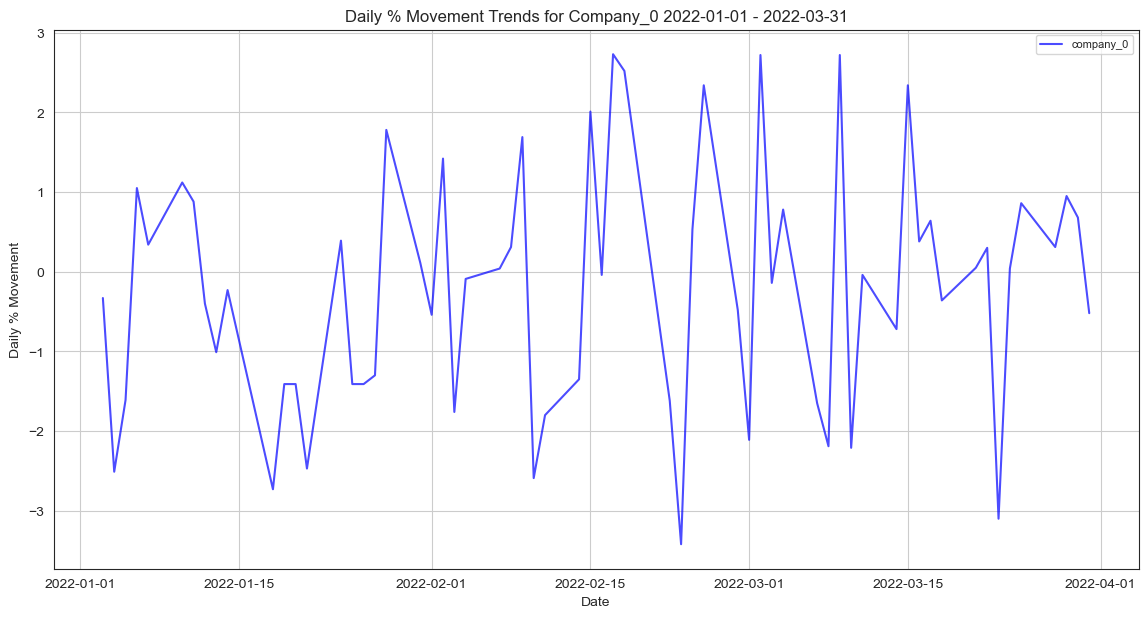

In [10]:
# First ten companies
selected_companies = data_t.loc["2022-01-01":].columns[:1]
sns.set_style("white") 
plt.figure(figsize=(14, 7))
for company in selected_companies:
    plt.plot(data_t.loc["2022-01-01":].index, data_t.loc["2022-01-01":][company], label=company, alpha=0.7, color="blue")

plt.xlabel('Date')
plt.ylabel('Daily % Movement')
plt.title('Daily % Movement Trends for Company_0 2022-01-01 - 2022-03-31')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

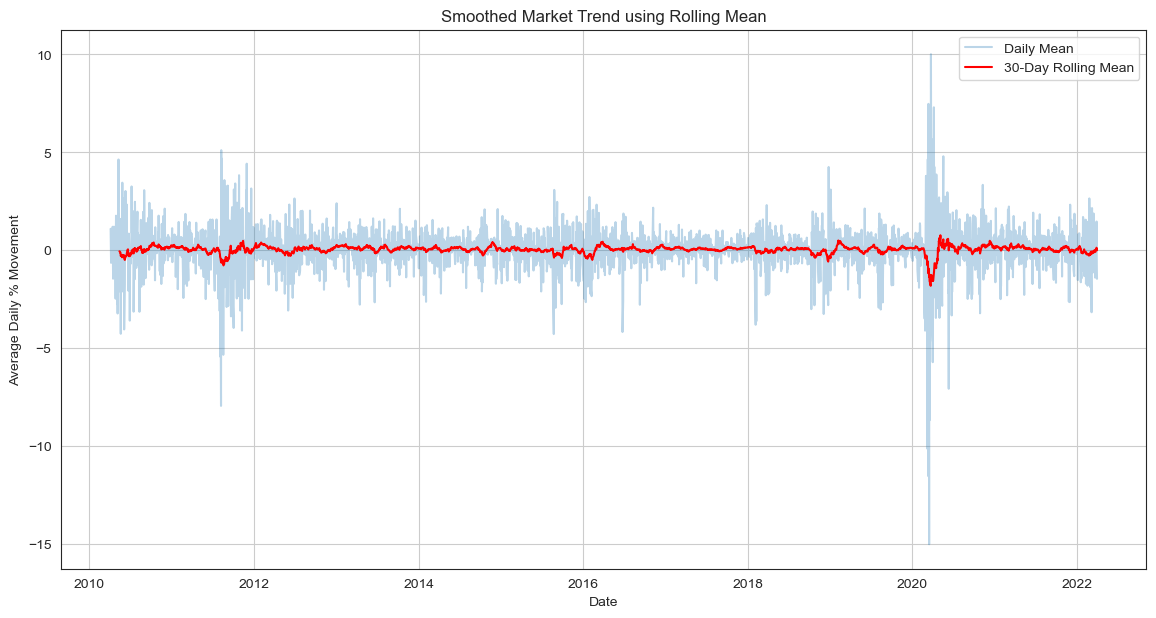

In [11]:
rolling_window = 30  # days
rolling_mean = data_t.mean(axis=1).rolling(window=rolling_window).mean()
sns.set_style("white") 

plt.figure(figsize=(14, 7))
plt.plot(data_t.index, data_t.mean(axis=1), alpha=0.3, label='Daily Mean')
plt.plot(data_t.index, rolling_mean, color='red', label=f'{rolling_window}-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Average Daily % Movement')
plt.title('Smoothed Market Trend using Rolling Mean')
plt.legend()
plt.grid(True)
plt.show()

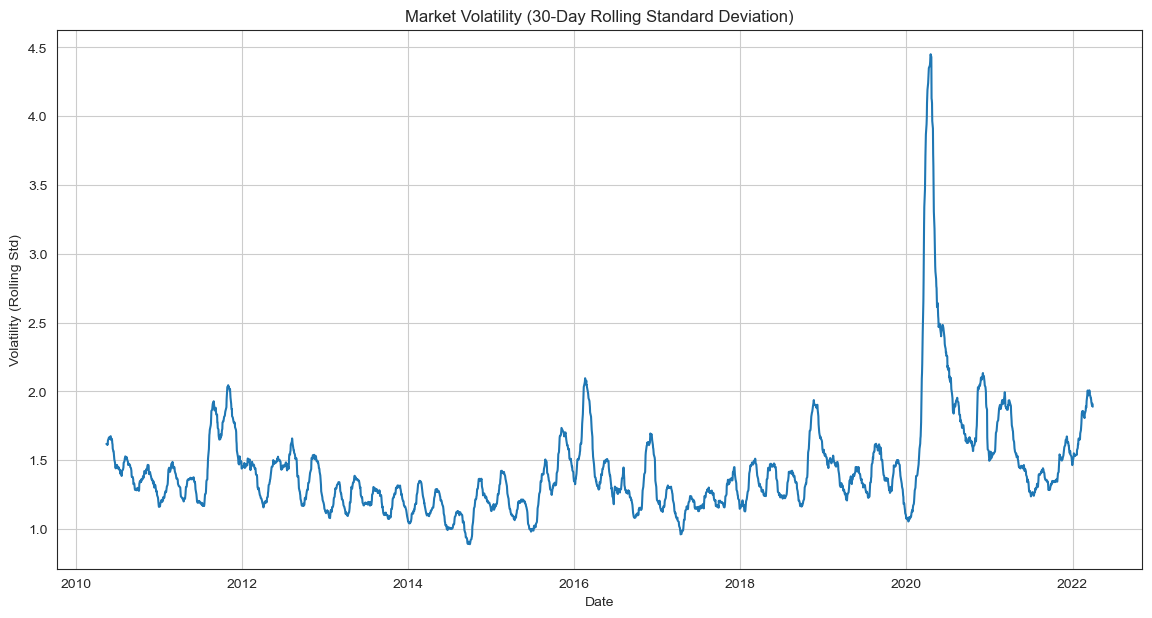

In [12]:
rolling_std = data_t.std(axis=1).rolling(window=30).mean()
sns.set_style("white") 
plt.figure(figsize=(14, 7))
plt.plot(data_t.index, rolling_std, )
plt.xlabel('Date')
plt.ylabel('Volatility (Rolling Std)')
plt.title('Market Volatility (30-Day Rolling Standard Deviation)')
plt.grid(True)
plt.show()

## Time-Based Data Split

To avoid data leakage in this time-series problem, we split the data:

- **Train**: 2010-04-05 to 2021-01-15 (2717 rows) (90%)
- **Validation**: 2021-01-19 to 2022-03-31 (304 rows) (10%)

This ensures future data does not influence training.

In [14]:
def train_val_90_10_split(data_t):
    """
    Splits the time series into 90% train, 10% validation by date.
    """
    # Full date range
    full_index = data_t.index
    start_date = full_index[0]
    end_date   = full_index[-1]

    # Calculate how many days is 10% of the entire timeline
    total_days = (end_date - start_date).days
    val_days   = int(total_days * 0.10)  # 10% of total

    # Start validation window val_days before the end of the data
    val_start = end_date - pd.Timedelta(days=val_days)

    # Note: the slice is inclusive of val_start; 
    # if you prefer strictly 90%/10% by count, you can adjust as needed.
    train_df = data_t.loc[:val_start]
    val_df   = data_t.loc[val_start:]

    print("Date range:", start_date.date(), "to", end_date.date())
    print(f"Total days = {total_days}  -> 10% of timeline = {val_days} days")
    print("Train range: ", train_df.index[0].date(), "to", train_df.index[-1].date(), f"({len(train_df)} rows)")
    print("Val range:   ", val_df.index[0].date(),   "to", val_df.index[-1].date(),   f"({len(val_df)} rows)")
    return train_df, val_df

train_data, val_data = train_val_90_10_split(data_t)

Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)


## Data Preparation Functions

The sequence is generated here

In [15]:
# generates a series
def generate_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = torch.tensor(data[i:i+seq_length], dtype=torch.float32)
        target = torch.tensor(data[i+1:i+seq_length+1], dtype=torch.float32)
        sequences.append(seq)
        targets.append(target)
    return sequences, targets

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


## Define LSTM Model

This is a simple LSTM network with configurable `latent_dim` and `num_layers` (hyperparameters) to model the temporal dependencies in the time-series data.

This model returns both the output sequence and the hidden state.
This model returns the output sequence. TODO: remove

In [16]:
def create_model(input_dim, latent_dim, output_dim, num_layers, ):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.input_dim  = input_dim
            self.hidden_dim = latent_dim
            self.num_layers = num_layers
            self.rnn1   = nn.LSTM(input_dim, latent_dim, num_layers, batch_first=True)
            self.linear = nn.Linear(latent_dim, output_dim)

        def init_hidden(self, batch_size):
            return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

        def forward(self, x):
            batch_size = x.size(0)
            h = self.init_hidden(batch_size)
            y, h = self.rnn1(x, h)
            y = self.linear(y[:, -1, :])
            return y

    model = Net()
    return model


## Training and Evaluation Functions

This is used to train and evaluate our LSTM model. The loss function used is MSELoss, and it tracks the validation loss to monitor generalization.

In [39]:
def train_one_model(model, X_train, y_train, X_val, y_val, epochs=30, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val_t   = torch.tensor(X_val,   dtype=torch.float32).to(device)
    y_val_t   = torch.tensor(y_val,   dtype=torch.float32).to(device)

    for epoch in range(epochs):
        model.zero_grad()
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_t)
        loss  = criterion(preds, y_train_t)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} MSE: {loss.item()}")
    
    print('Training complete.')

    # Evaluate on val
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss  = criterion(val_preds, y_val_t).item()
        
    print(f"Validation MSE: {val_loss}")
    return val_loss

## Optuna

In [40]:
n_companies = 442

In [55]:
# Objective with time series split
def objective(trial):
    latent_dim = trial.suggest_int("latent_dim", 4, 256, step=4)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate= trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    sequence_length = trial.suggest_int('sequence_length', 5, 30)

    # Prepare data
    _, normalized_data, _ = preprocess_data()
    X, y = create_sequences(normalized_data, sequence_length)
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Convert to PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train)
        X_val = torch.FloatTensor(X_val)
        y_val = torch.FloatTensor(y_val)
        
        # Model setup
        model = create_model(
        input_dim=n_companies,
        latent_dim=latent_dim,
        output_dim=n_companies,
        num_layers=num_layers,
        )

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training
        for epoch in range(50):
            # print("epoch", epoch)
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)
            cv_scores.append(val_loss.item())

        print("training loss", loss.item(), "validation loss", val_loss)
    
    return np.mean(cv_scores)

# Objective with 90% -> more effective
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr         = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    seq_length = trial.suggest_int("sequence_length", 5, 30)

    # We'll load the same dataset each time
    train_df, val_df = train_val_90_10_split(data_t.copy() )

    # Fit the scaler ONLY on the training set
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_df)
    val_scaled   = scaler.transform(val_df)

    # 3) Build sequences
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_val,   y_val   = create_sequences(val_scaled, seq_length)

    print(train_df.shape[1])
    # Instantiate the model & train
    model = create_model(
        input_dim=n_companies,
        latent_dim=hidden_dim,
        output_dim=n_companies,
        num_layers=num_layers,
        ).to(device)

    val_loss = train_one_model(model, X_train, y_train, X_val, y_val,
                               epochs=30, lr=lr)
    return val_loss

In [42]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best result
print("Best trial:")
print(f"  Loss: {study.best_value:.4f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2025-03-27 15:35:16,010] A new study created in memory with name: no-name-131e6638-3bb6-4daa-9bd1-76554b432768


Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06526751816272736
Epoch 10 MSE: 0.01362652238458395
Epoch 20 MSE: 0.012449225410819054


[I 2025-03-27 15:35:27,652] Trial 0 finished with value: 0.011769591830670834 and parameters: {'hidden_dim': 224, 'num_layers': 1, 'learning_rate': 0.0035858226953168573, 'sequence_length': 29}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011769591830670834
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.07263657450675964
Epoch 10 MSE: 0.051615551114082336
Epoch 20 MSE: 0.035269059240818024
Training complete.


[I 2025-03-27 15:35:28,444] Trial 1 finished with value: 0.022310998290777206 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'learning_rate': 0.00028356970254423417, 'sequence_length': 5}. Best is trial 0 with value: 0.011769591830670834.


Validation MSE: 0.022310998290777206
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06434705853462219
Epoch 10 MSE: 0.045481495559215546
Epoch 20 MSE: 0.01957399956882


[I 2025-03-27 15:35:54,870] Trial 2 finished with value: 0.013484503142535686 and parameters: {'hidden_dim': 224, 'num_layers': 3, 'learning_rate': 0.00022730658624408828, 'sequence_length': 24}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.013484503142535686
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06545782089233398
Epoch 10 MSE: 0.06020782142877579
Epoch 20 MSE: 0.05132404714822769


[I 2025-03-27 15:36:04,209] Trial 3 finished with value: 0.03605977073311806 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'learning_rate': 0.0001302701108532269, 'sequence_length': 20}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.03605977073311806
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.0706699937582016
Epoch 10 MSE: 0.015330548398196697
Epoch 20 MSE: 0.013092469424009323


[I 2025-03-27 15:36:06,153] Trial 4 finished with value: 0.012078777886927128 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.0069723908934826145, 'sequence_length': 23}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012078777886927128
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.0701896920800209
Epoch 10 MSE: 0.01487560011446476
Epoch 20 MSE: 0.012744665145874023


[I 2025-03-27 15:36:07,750] Trial 5 finished with value: 0.012193717993795872 and parameters: {'hidden_dim': 160, 'num_layers': 1, 'learning_rate': 0.002386251227550135, 'sequence_length': 7}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012193717993795872
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06567420810461044
Epoch 10 MSE: 0.023783359676599503
Epoch 20 MSE: 0.014021565206348896


[I 2025-03-27 15:36:10,422] Trial 6 finished with value: 0.01261882483959198 and parameters: {'hidden_dim': 192, 'num_layers': 1, 'learning_rate': 0.0004341987764225278, 'sequence_length': 10}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.01261882483959198
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06244046241044998
Epoch 10 MSE: 0.04162725433707237
Epoch 20 MSE: 0.01885443739593029


[I 2025-03-27 15:36:37,181] Trial 7 finished with value: 0.01275595836341381 and parameters: {'hidden_dim': 192, 'num_layers': 3, 'learning_rate': 0.0002674064914364885, 'sequence_length': 30}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.01275595836341381
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06830795854330063
Epoch 10 MSE: 0.05080753564834595
Epoch 20 MSE: 0.03125030919909477


[I 2025-03-27 15:36:40,388] Trial 8 finished with value: 0.017805462703108788 and parameters: {'hidden_dim': 96, 'num_layers': 2, 'learning_rate': 0.0003410706037307066, 'sequence_length': 15}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.017805462703108788
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06313692033290863
Epoch 10 MSE: 0.013667121529579163
Epoch 20 MSE: 0.012545146048069


[I 2025-03-27 15:36:55,194] Trial 9 finished with value: 0.011812470853328705 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'learning_rate': 0.0018278952082876332, 'sequence_length': 30}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011812470853328705
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06370608508586884
Epoch 10 MSE: 0.017065059393644333
Epoch 20 MSE: 0.013221962377429008


[I 2025-03-27 15:37:08,786] Trial 10 finished with value: 0.012207988649606705 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'learning_rate': 0.007737121802873221, 'sequence_length': 15}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012207988649606705
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06279388815164566
Epoch 10 MSE: 0.013670518063008785
Epoch 20 MSE: 0.012551023624837399


[I 2025-03-27 15:37:23,065] Trial 11 finished with value: 0.011815194971859455 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'learning_rate': 0.0017763662125277887, 'sequence_length': 30}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011815194971859455
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06774555891752243
Epoch 10 MSE: 0.013575825840234756
Epoch 20 MSE: 0.01243731938302517


[I 2025-03-27 15:37:35,053] Trial 12 finished with value: 0.011917193420231342 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'learning_rate': 0.0032078258803890708, 'sequence_length': 25}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011917193420231342
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06639470160007477
Epoch 10 MSE: 0.014952604658901691
Epoch 20 MSE: 0.013063166290521622


[I 2025-03-27 15:37:45,694] Trial 13 finished with value: 0.011995963752269745 and parameters: {'hidden_dim': 224, 'num_layers': 1, 'learning_rate': 0.0009246409511245036, 'sequence_length': 27}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011995963752269745
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06565886735916138
Epoch 10 MSE: 0.015204272232949734
Epoch 20 MSE: 0.013013134710490704


[I 2025-03-27 15:37:57,661] Trial 14 finished with value: 0.012036153115332127 and parameters: {'hidden_dim': 192, 'num_layers': 2, 'learning_rate': 0.0013009547625862533, 'sequence_length': 20}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012036153115332127
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06671545654535294
Epoch 10 MSE: 0.01469516847282648
Epoch 20 MSE: 0.012701288796961308


[I 2025-03-27 15:38:08,801] Trial 15 finished with value: 0.011922333389520645 and parameters: {'hidden_dim': 224, 'num_layers': 1, 'learning_rate': 0.004365036864030636, 'sequence_length': 27}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011922333389520645
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06481470167636871
Epoch 10 MSE: 0.02001631259918213
Epoch 20 MSE: 0.013662781566381454


[I 2025-03-27 15:38:23,540] Trial 16 finished with value: 0.012044272385537624 and parameters: {'hidden_dim': 160, 'num_layers': 2, 'learning_rate': 0.00071622527654497, 'sequence_length': 30}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012044272385537624
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.06571563333272934
Epoch 10 MSE: 0.013992488384246826
Epoch 20 MSE: 0.012567480094730854


[I 2025-03-27 15:38:34,147] Trial 17 finished with value: 0.011985746212303638 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'learning_rate': 0.004324850416887338, 'sequence_length': 21}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.011985746212303638
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.09542692452669144
Epoch 10 MSE: 0.04958605766296387
Epoch 20 MSE: 0.025129275396466255


[I 2025-03-27 15:38:35,818] Trial 18 finished with value: 0.015478882007300854 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.0018099250064808421, 'sequence_length': 27}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.015478882007300854
Date range: 2010-04-05 to 2022-03-31
Total days = 4378  -> 10% of timeline = 437 days
Train range:  2010-04-05 to 2021-01-15 (2717 rows)
Val range:    2021-01-19 to 2022-03-31 (304 rows)
Epoch 0 MSE: 0.062332943081855774
Epoch 10 MSE: 0.017077745869755745
Epoch 20 MSE: 0.013951882719993591


[I 2025-03-27 15:38:47,532] Trial 19 finished with value: 0.012006114237010479 and parameters: {'hidden_dim': 224, 'num_layers': 2, 'learning_rate': 0.009926559658610796, 'sequence_length': 15}. Best is trial 0 with value: 0.011769591830670834.


Training complete.
Validation MSE: 0.012006114237010479
Best trial:
  Loss: 0.0118
  Params:
    hidden_dim: 224
    num_layers: 1
    learning_rate: 0.0035858226953168573
    sequence_length: 29


/var/folders/s5/l7rgsqns79v0y6svkxh5whqm0000gn/T/ipykernel_9631/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

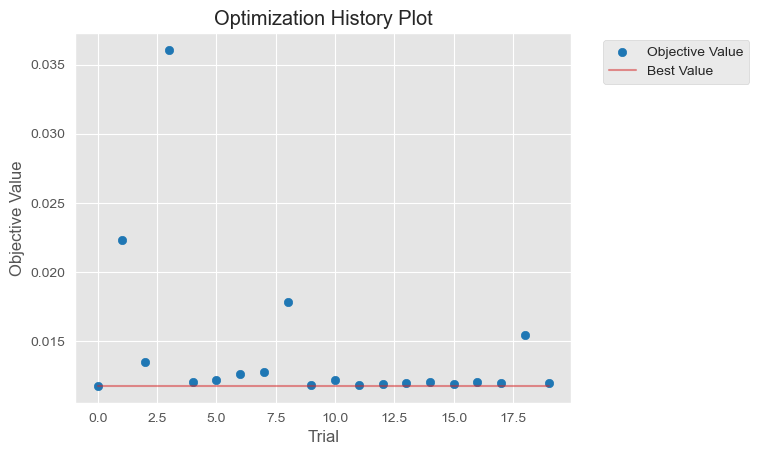

In [43]:
optuna.visualization.matplotlib.plot_optimization_history(study)

## Final Model Training with Best Optuna Hyperparameters

This step involves creating the final model using the best hyperparameters found by Optuna and evaluate its performance


In [ ]:
# Get best hyperparams
best_params = study.best_params
print("Using Best Hyperparameters:", best_params)

# Prepare final data
ids, normalized_data, scaler = preprocess_data()
X, y = create_sequences(normalized_data, best_params['sequence_length'])

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

final_model = create_model(
        input_dim=n_companies,
        latent_dim=best_params['hidden_dim'],
        output_dim=n_companies,
        num_layers=best_params['num_layers'],
        )

# Training final model
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

for epoch in range(100):
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Forecast for 1st April 2022
final_model.eval()
with torch.no_grad():
    last_sequence = torch.FloatTensor(normalized_data[-best_params['sequence_length']:])
    forecast = final_model(last_sequence.unsqueeze(0))

# Convert prediction to NumPy
forecast_np = forecast.numpy()

# Inverse transform back to original scale
forecast_original = scaler.inverse_transform(forecast_np)

Using Best Hyperparameters: {'hidden_dim': 224, 'num_layers': 1, 'learning_rate': 0.0035858226953168573, 'sequence_length': 29}


## Generate Submission

In [46]:
# Save submission
submission_df = pd.DataFrame({
    'ID': data_t.columns, 
    'value': forecast_original.flatten() 
})
submission_df.to_csv("submission.csv", index=False)
  
submission_df

,ID,value
0,company_0,0.204933
1,company_1,0.137456
2,company_2,0.172852
3,company_3,0.471318
4,company_4,0.373137
...,...,...
437,company_437,0.031021
438,company_438,0.562835
439,company_439,0.220485
440,company_440,0.282154


In [47]:
submission_df["value"].max(), submission_df["value"].min()

(2.502077579498291, -0.29413267970085144)

## Model Interpretation with Captum

Integrated Gradients, and LayerConductance from Captum are used to interpret the model’s prediction . This highlights the most influential time steps in the input sequence.

- **Integrated Gradients** tells us how each input contributed to the final prediction.
- **Layer Conductance** shows how hidden layer neurons influenced the output.



In [48]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

### Integrated Gradients

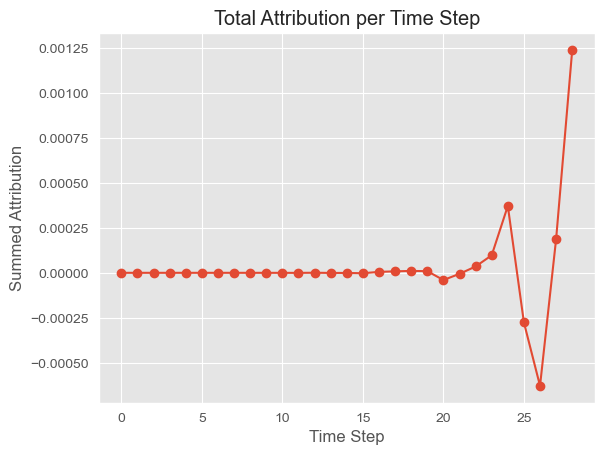

In [49]:
# Define model wrapper
class WrappedModel(nn.Module):
    def __init__(self, model, company_index=0):
        super().__init__()
        self.model = model
        self.company_index = company_index

    def forward(self, x):
        output = self.model(x)
        # if output.ndim == 1:
        output = output.unsqueeze(0)
        return output[:, self.company_index]


# Prepare validation input
val_data = scaler.inverse_transform(normalized_data)[-60:]  # last 60 days
X_val, y_val = create_sequences(val_data, best_params['sequence_length'])
X_val_tensor = torch.FloatTensor(X_val)
X_sample = X_val_tensor[0:1].clone().detach()
X_sample.requires_grad = True

# Run Captum
wrapped_model = WrappedModel(final_model, company_index=0)
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(X_sample, target=0, return_convergence_delta=True)

# Plot attributions - TOO noisy
# attr_sum = attributions.squeeze(0).detach().numpy()
# plt.plot(attr_sum)
# plt.title("Integrated Gradients Attribution NOisy")
# plt.xlabel("Time Step")
# plt.ylabel("Importance")
# plt.grid(True)
# plt.show()


attr_summed = attributions.squeeze(0).sum(dim=1).detach().numpy()

plt.plot(attr_summed, marker='o')
plt.title("Total Attribution per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Summed Attribution")
plt.grid(True)
plt.show()



** Chart Summary**: This chart shows how much influence each day in the past had on the model’s forecast for April 1st, 2022.

- X-axis: Time steps in the input sequence (from earliest to latest day).
- Y-axis: Total importance (summed attribution) across all companies for that time step.

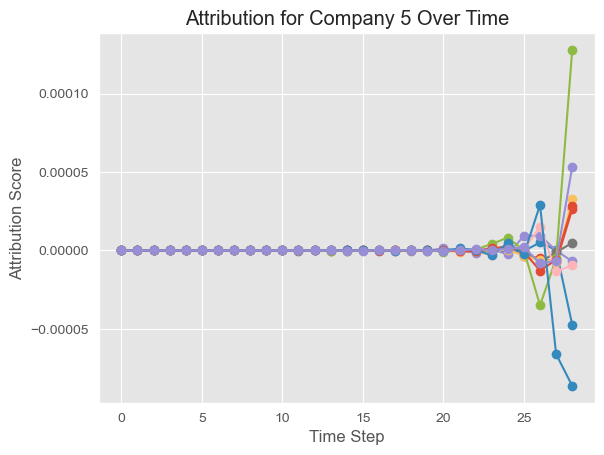

In [54]:

company_index = 0
for company_index in range(10):
    attr_single_company = attributions.squeeze(0)[:, company_index].detach().numpy()
    plt.plot(attr_single_company, marker='o', label=company_index)
plt.title("Attribution for Company 5 Over Time")
plt.xlabel("Time Step")
plt.ylabel("Attribution Score")
plt.grid(True)
plt.show()


**Chart Summary**: Attribution for Companies 0–4 Over Time
This chart shows the Integrated Gradients attribution scores over time for the first 5 companies in your dataset.



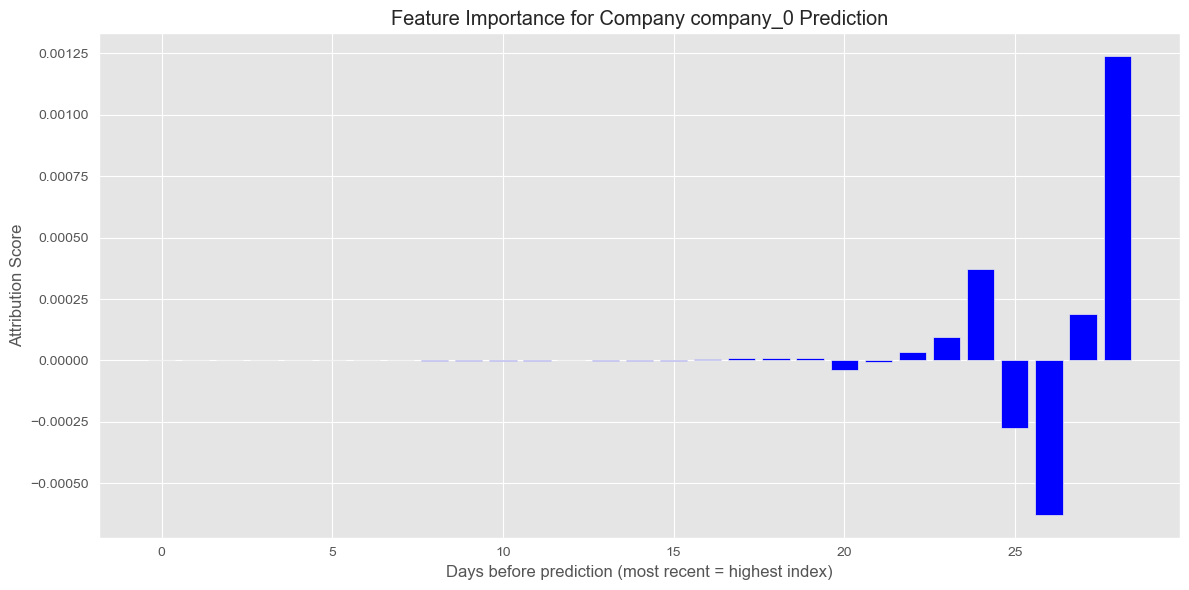

Top 5 most influential days for Company company_0: [28 26 24 25 27]


In [51]:
attributions_1d = attributions.detach().squeeze(0).sum(dim=1).numpy()
company_id = "company_0"

plt.figure(figsize=(12, 6))
plt.bar(range(len(attributions_1d)), attributions_1d, color='blue')
plt.title(f"Feature Importance for Company {company_id} Prediction")
plt.xlabel("Days before prediction (most recent = highest index)")
plt.ylabel("Attribution Score")
plt.tight_layout()
plt.show()

# Print top 5 influential days based on attribution
top5_indices = np.argsort(np.abs(attributions_1d))[-5:][::-1]
print(f"Top 5 most influential days for Company {company_id}: {top5_indices}")


**Summary** Feature Importance for Company company_0
This bar chart shows the Integrated Gradients attribution scores across time steps for Company 0, revealing how much each day contributed to the model's forecast for that company.

- X-axis: Time steps before prediction (0 = oldest, 6 = most recent day)
- Y-axis: Attribution score (feature importance) Each bar shows how much that specific day’s input value (for Company 0) contributed to the final prediction.